In [1]:
# ! pip install planetary-computer
# !pip install geogif
# !pip install stackstac
# ! pip install dask distributed 
import dask
import pystac_client
import planetary_computer as pc
import leafmap
import geogif
import stackstac
from dask.distributed import Client, LocalCluster
import leafmap

In [2]:
cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 23.71 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:59264,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 23.71 GiB
Comm: tcp://127.0.0.1:59288,Total threads: 3
Dashboard: http://127.0.0.1:59290/status,Memory: 5.93 GiB
Nanny: tcp://127.0.0.1:59267,


In [3]:
m = leafmap.Map(center=[39.9334, 32.8597], zoom=12, height="450px")
m

Map(center=[39.9334, 32.8597], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zo…

In [5]:
bbox = (m.west, m.south, m.east, m.north)
bbox

(32.66784667968751, 39.787961519016065, 33.17459106445313, 40.024985445869184)

In [6]:
catalog = pystac_client.Client.open('https://planetarycomputer.microsoft.com/api/stac/v1')

search = catalog.search(
    collections=['landsat-8-c2-l2'],
    bbox=bbox,
)

In [7]:
items = pc.sign(search)
len(items)

597

In [8]:
m.add_geojson(items.to_dict())
m

Map(bottom=198887.0, center=[39.90662858254702, 32.92145830728098], controls=(ZoomControl(options=['position',…

In [9]:
print(bbox)
print(len(items))

(32.66784667968751, 39.787961519016065, 33.17459106445313, 40.024985445869184)
597


In [40]:
filtered_items = [item for item in items if item.bbox]
bbox_4326 = [item.bbox for item in filtered_items]
west = min(b[0] for b in bbox_4326)
south = min(b[1] for b in bbox_4326)
east = max(b[2] for b in bbox_4326)
north = max(b[3] for b in bbox_4326)
combined_bbox = (west, south, east, north)
stack = stackstac.stack(filtered_items, bounds_latlon=combined_bbox, epsg=4326, resolution=0.1)
stack

<xarray.DataArray 'stackstac-77042c1113fe20bf9d78cfbe1116da7d' (time: 586,
                                                                band: 19,
                                                                y: 37, x: 56)> Size: 185MB
dask.array<fetch_raster_window, shape=(586, 19, 37, 56), dtype=float64, chunksize=(1, 1, 37, 56), chunktype=numpy.ndarray>
Coordinates: (12/27)
  * time                         (time) datetime64[ns] 5kB 2013-03-19T08:27:5...
    id                           (time) <U31 73kB 'LC08_L2SP_177032_20130319_...
  * band                         (band) <U13 988B 'SR_B1' ... 'SR_QA_AEROSOL'
  * x                            (x) float64 448B 30.2 30.3 30.4 ... 35.6 35.7
  * y                            (y) float64 296B 41.5 41.4 41.3 ... 38.0 37.9
    eo:cloud_cover               (time) float64 5kB 85.5 78.52 ... 3.38 27.55
    ...                           ...
    gsd                          (band) float64 152B 30.0 30.0 ... 30.0 30.0
    title                        (band) <U46 3kB 'Coastal/Aerosol Band (B1)' ...
    common_name                  (band) object 152B 'coastal' 'blue' ... None
    center_wavelength            (band) object 152B 0.44 0.48 0.56 ... None None
    full_width_half_max          (band) object 152B 0.02 0.06 0.06 ... None None
    epsg                         int32 4B 4326
Attributes:
    spec:        RasterSpec(epsg=4326, bounds=(30.200000000000003, 37.8000000...
    crs:         epsg:4326
    transform:   | 0.10, 0.00, 30.20|\n| 0.00,-0.10, 41.50|\n| 0.00, 0.00, 1.00|
    resolution:  0.1

In [41]:
# Use common_name for bands
stack = stack.assign_coords(band=stack.common_name.fillna(stack.band).rename("band"))
stack.band

<xarray.DataArray 'band' (band: 19)> Size: 152B
array(['coastal', 'blue', 'green', 'red', 'nir08', 'swir16', 'swir22', 'ST_QA',
       'lwir11', 'ST_DRAD', 'ST_EMIS', 'ST_EMSD', 'ST_TRAD', 'ST_URAD',
       'QA_PIXEL', 'ST_ATRAN', 'ST_CDIST', 'QA_RADSAT', 'SR_QA_AEROSOL'],
      dtype=object)
Coordinates: (12/15)
    proj:code                  <U10 40B 'EPSG:32636'
    landsat:wrs_type           <U1 4B '2'
    landsat:processing_level   <U4 16B 'L2SP'
    view:off_nadir             int32 4B 0
    landsat:collection_number  <U2 8B '02'
    instruments                object 8B {'oli', 'tirs'}
    ...                         ...
    title                      (band) <U46 3kB 'Coastal/Aerosol Band (B1)' .....
    common_name                (band) object 152B 'coastal' 'blue' ... None None
    center_wavelength          (band) object 152B 0.44 0.48 0.56 ... None None
    full_width_half_max        (band) object 152B 0.02 0.06 0.06 ... None None
    epsg                       int32 4B 4326
  * band                       (band) object 152B 'coastal' ... 'SR_QA_AEROSOL'

In [42]:
stack.sel(band=["red", "green", "blue"])

<xarray.DataArray 'stackstac-77042c1113fe20bf9d78cfbe1116da7d' (time: 586,
                                                                band: 3, y: 37,
                                                                x: 56)> Size: 29MB
dask.array<getitem, shape=(586, 3, 37, 56), dtype=float64, chunksize=(1, 1, 37, 56), chunktype=numpy.ndarray>
Coordinates: (12/27)
  * time                         (time) datetime64[ns] 5kB 2013-03-19T08:27:5...
    id                           (time) <U31 73kB 'LC08_L2SP_177032_20130319_...
  * x                            (x) float64 448B 30.2 30.3 30.4 ... 35.6 35.7
  * y                            (y) float64 296B 41.5 41.4 41.3 ... 38.0 37.9
    eo:cloud_cover               (time) float64 5kB 85.5 78.52 ... 3.38 27.55
    proj:code                    <U10 40B 'EPSG:32636'
    ...                           ...
    title                        (band) <U46 552B 'Red Band (B4)' ... 'Blue B...
    common_name                  (band) object 24B 'red' 'green' 'blue'
    center_wavelength            (band) object 24B 0.65 0.56 0.48
    full_width_half_max          (band) object 24B 0.04 0.06 0.06
    epsg                         int32 4B 4326
  * band                         (band) object 24B 'red' 'green' 'blue'
Attributes:
    spec:        RasterSpec(epsg=4326, bounds=(30.200000000000003, 37.8000000...
    crs:         epsg:4326
    transform:   | 0.10, 0.00, 30.20|\n| 0.00,-0.10, 41.50|\n| 0.00, 0.00, 1.00|
    resolution:  0.1

In [43]:
# Make a bitmask---when we bitwise-and it with the data, it leaves just the 4 bits we care about
# https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/media/files/LSDS-1619_Landsat-8-9-C2-L2-ScienceProductGuide-v4.pdf 
mask_bitfields = [1, 2, 3, 4]  # dilated cloud, cirrus, cloud, cloud shadow
bitmask = 0
for field in mask_bitfields:
    bitmask |= 1 << field

bin(bitmask)

'0b11110'

In [44]:
qa = stack.sel(band="QA_PIXEL").astype("uint16")
bad = qa & bitmask  # just look at those 4 bits

good = stack.where(bad == 0)  # mask pixels where any one of those bits are set

(array([195.,   1., 380.,   0.,   8.,   0.,   0.,   0.,   0.,   1.]),
 array([ 0. ,  3.4,  6.8, 10.2, 13.6, 17. , 20.4, 23.8, 27.2, 30.6, 34. ]),
 <BarContainer object of 10 artists>)

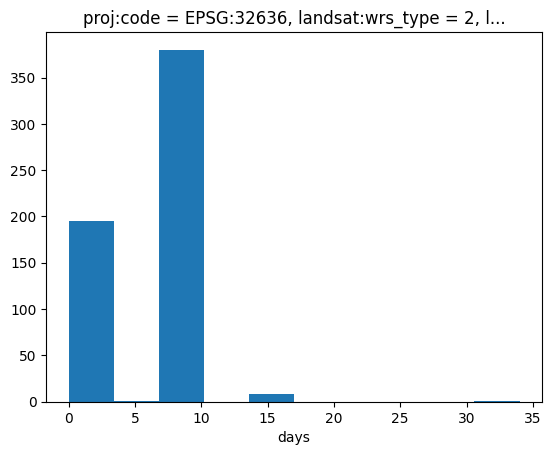

In [45]:
# What's the typical interval between scenes?
good.time.diff("time").dt.days.plot.hist()

In [46]:
# Make biannual median composites (`2Q` means 2 quarters)
composites = good.resample(time="2Q").median("time")
composites

<xarray.DataArray 'stackstac-77042c1113fe20bf9d78cfbe1116da7d' (time: 19,
                                                                band: 19,
                                                                y: 37, x: 56)> Size: 6MB
dask.array<stack, shape=(19, 19, 37, 56), dtype=float64, chunksize=(1, 19, 37, 56), chunktype=numpy.ndarray>
Coordinates:
  * x                          (x) float64 448B 30.2 30.3 30.4 ... 35.6 35.7
  * y                          (y) float64 296B 41.5 41.4 41.3 ... 38.0 37.9
    proj:code                  <U10 40B 'EPSG:32636'
    landsat:wrs_type           <U1 4B '2'
    landsat:processing_level   <U4 16B 'L2SP'
    view:off_nadir             int32 4B 0
    landsat:collection_number  <U2 8B '02'
    instruments                object 8B {'oli', 'tirs'}
    platform                   <U9 36B 'landsat-8'
    epsg                       int32 4B 4326
  * band                       (band) object 152B 'coastal' ... 'SR_QA_AEROSOL'
  * time                       (time) datetime64[ns] 152B 2013-03-31 ... 2022...
Attributes:
    spec:        RasterSpec(epsg=4326, bounds=(30.200000000000003, 37.8000000...
    crs:         epsg:4326
    transform:   | 0.10, 0.00, 30.20|\n| 0.00,-0.10, 41.50|\n| 0.00, 0.00, 1.00|
    resolution:  0.1

In [47]:
rgb = composites.sel(band=["red", "green", "blue"])
rgb

<xarray.DataArray 'stackstac-77042c1113fe20bf9d78cfbe1116da7d' (time: 19,
                                                                band: 3, y: 37,
                                                                x: 56)> Size: 945kB
dask.array<getitem, shape=(19, 3, 37, 56), dtype=float64, chunksize=(1, 3, 37, 56), chunktype=numpy.ndarray>
Coordinates:
  * x                          (x) float64 448B 30.2 30.3 30.4 ... 35.6 35.7
  * y                          (y) float64 296B 41.5 41.4 41.3 ... 38.0 37.9
    proj:code                  <U10 40B 'EPSG:32636'
    landsat:wrs_type           <U1 4B '2'
    landsat:processing_level   <U4 16B 'L2SP'
    view:off_nadir             int32 4B 0
    landsat:collection_number  <U2 8B '02'
    instruments                object 8B {'oli', 'tirs'}
    platform                   <U9 36B 'landsat-8'
    epsg                       int32 4B 4326
  * band                       (band) object 24B 'red' 'green' 'blue'
  * time                       (time) datetime64[ns] 152B 2013-03-31 ... 2022...
Attributes:
    spec:        RasterSpec(epsg=4326, bounds=(30.200000000000003, 37.8000000...
    crs:         epsg:4326
    transform:   | 0.10, 0.00, 30.20|\n| 0.00,-0.10, 41.50|\n| 0.00, 0.00, 1.00|
    resolution:  0.1

In [48]:
cleaned = rgb.ffill("time")[1:]


In [ ]:
gif_img = geogif.dgif(cleaned).compute()

In [ ]:
dask.utils.format_bytes(len(gif_img.data))